In [60]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers as tf_layers

import matplotlib as mpl
from matplotlib import pyplot as plt

from jmd_imagescraper.core import *
from pathlib import Path
import shutil
import time

# Discriminator model

In [179]:
def convolution_block(n_filters):
    return [tf_layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same'),
            tf_layers.BatchNormalization(),
            tf_layers.LeakyReLU(alpha=0.2)]

def make_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(64, 64, 3)),
        *convolution_block(64),
        *convolution_block(128),
        *convolution_block(128),
        tf_layers.Flatten(),
        tf_layers.Dropout(0.2),
        tf_layers.Dense(1, activation='sigmoid')
    ])

tuple(make_discriminator_model().layers[-3].input.shape)[1:]

(8, 8, 128)

# Generator model

In [180]:
def transpose_convolution_block(n_filters):
    return [tf_layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same'),
            tf_layers.LeakyReLU(alpha=0.2)]

def make_generator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(128,)),
        tf_layers.Dense(8192), # 8 * 8 * 128 = 8192
        tf_layers.Reshape((8, 8, 128)),
        *transpose_convolution_block(128),
        *transpose_convolution_block(256),
        *transpose_convolution_block(512),
        tf_layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')
    ])

tuple(make_generator_model().output_shape)[1:]

(64, 64, 3)

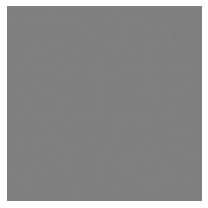

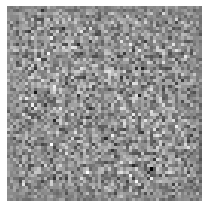

In [63]:
test_generator = make_generator_model()
input_noise = tf.random.normal((1, 128))
generated_image = test_generator(input_noise, training=False)

plt.rcParams['figure.figsize'] = [3, 3]
plt.imshow(generated_image[0, :, :], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('plots/noise_generated_image.jpg')
plt.show()

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('plots/noise_generated_image_first_dim.jpg')
plt.show()

# Dataset

## Download

In [64]:
root_dir = Path().cwd()/"downloaded_images"

##### Uncomment to download the dataset #####
# CLASS_NAME = 'spaghetti_bolognese'
# SEARCH_PHRASE = 'spaghetti bolognese'
# N_DOWNLOAD = 500

# if root_dir.exists():
#     shutil.rmtree(root_dir)
# duckduckgo_search(root_dir, CLASS_NAME, SEARCH_PHRASE, max_results=N_DOWNLOAD)
# None

Found 345 files belonging to 1 classes.


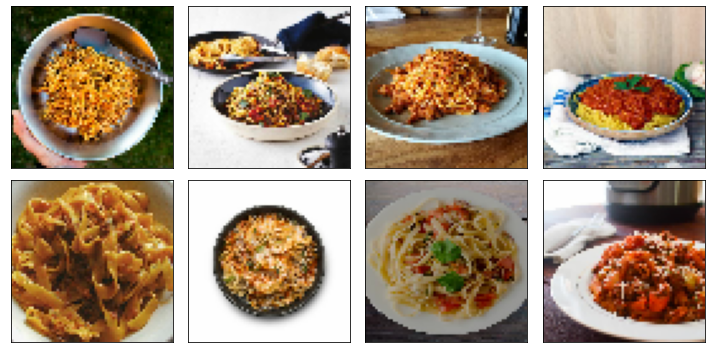

In [65]:
BATCH_SIZE = 8

dataset = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                      labels=None,
                                                      image_size=(64, 64),
                                                      shuffle=True)
dataset_images = np.array(list(dataset.unbatch()))
dataset_images = dataset_images[:(dataset_images.shape[0] - dataset_images.shape[0] % BATCH_SIZE)]
dataset_images = np.array(tf_layers.Rescaling(1./255.)(dataset_images))

plt.rcParams['figure.figsize'] = [10, 5]
for i, image in enumerate(dataset_images[:8]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('plots/sample_images.jpg')
plt.show()

## Data augmentation

In [66]:
data_augmentation = tf.keras.Sequential([
    tf_layers.RandomFlip('horizontal'),
    tf_layers.RandomZoom(0.1),
    tf_layers.RandomRotation(0.1)
])

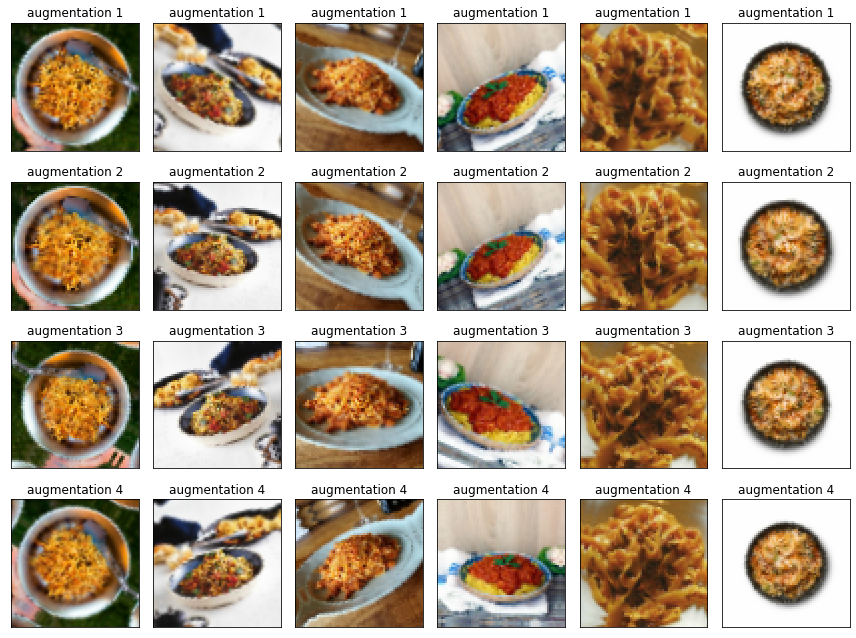

In [67]:
plt.rcParams['figure.figsize'] = [12, 9]
images = dataset_images[:6]
for i in range(4):
    for j, image in enumerate(data_augmentation(images)):
        plt.subplot(4, 6, i * 6 + j + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'augmentation {i + 1}')
    
plt.tight_layout()
plt.savefig('plots/sample_augmentations.jpg')
plt.show()

# Training

## Utils

In [68]:
def _moving_average(arr, n):
    cumsum = np.cumsum(np.concatenate(([0] * n, arr)))
    return (cumsum[n:] - cumsum[:-n]) / np.concatenate((np.arange(1, n + 1), np.full((len(arr) - n,), n)))

def _plot_score_vs_epochs(sub_idx, x, y, xlabel, ylabel, title=None, y_min=None, y_max=None, ma=10):
    y = _moving_average(y, ma)
    plt.subplot(1, 2, sub_idx)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
def plot_all_score_vs_epochs(model_history, save_path=None, loss_min=None, loss_max=None, ma=10, start_from=0):
    plt.rcParams['figure.figsize'] = [11, 5]
    
    x = np.arange(start_from + 1, start_from + len(model_history['discriminator_loss']) + 1)  
    
    _plot_score_vs_epochs(1, x, model_history['discriminator_loss'], 'epoch', 'discriminator_loss',
                          title='Discriminator Loss', ma=ma, y_min=loss_min, y_max=loss_max)
    _plot_score_vs_epochs(2, x, model_history['generator_loss'], 'epoch', 'generator_loss',
                          title='Generator Loss', ma=ma, y_min=loss_min, y_max=loss_max)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

## Warm-up

In [69]:
test_model = tf.keras.Sequential(layers =[
    tf.keras.Input(shape=(3,)),
    tf_layers.Dense(5),
    tf_layers.Dense(3)
])

test_input = tf.random.uniform((5, 3))
test_output = test_model.predict(test_input)

In [70]:
# sum of differences between 10. and absolute sum of output
def test_loss(output):
    return tf.math.reduce_sum(tf.abs(tf.math.reduce_sum(output, axis=1) - tf.constant(10.)))

test_loss(test_model.predict(test_input)).numpy()

42.412483

In [71]:
def test_gradient(model, input_):
    weights = model.layers[0].trainable_variables
    with tf.GradientTape() as tape:
        output = test_loss(model(input_))
        gradient = tape.gradient(output, weights)
    return gradient

test_gradient(test_model, test_input)

[<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[ 3.4590466 ,  2.4136918 ,  0.50359094, -1.1538607 ,  1.4647374 ],
        [ 4.367035  ,  3.047278  ,  0.635782  , -1.4567453 ,  1.8492262 ],
        [ 2.8430614 ,  1.983863  ,  0.41391176, -0.9483818 ,  1.203898  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([ 6.31058   ,  4.403466  ,  0.91873616, -2.1050687 ,  2.6722229 ],
       dtype=float32)>]

In [72]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

for i in range(1, 21):
    gradient = test_gradient(test_model, test_input)
    optimizer.apply_gradients(zip(gradient, test_model.layers[0].trainable_weights))
    print(f'{i}: {test_loss(test_model.predict(test_input)):0.2f}')

1: 40.99
2: 39.57
3: 38.15
4: 36.73
5: 35.31
6: 33.89
7: 32.47
8: 31.05
9: 29.63
10: 28.21
11: 26.79
12: 25.37
13: 23.95
14: 22.53
15: 21.11
16: 19.69
17: 18.27
18: 16.85
19: 15.43
20: 14.01


# Procedure

In [184]:
@tf.function
def discriminator_round(discriminator, generator, real_images, batch_size, loss_fun, optimizer):
    noise = tf.random.normal((batch_size, 128))
    
    with tf.GradientTape() as tape:
        generated_images = generator(noise, training=False) # ...
        X = tf.concat([real_images, generated_images], axis=0)
        y = tf.concat([tf.ones(batch_size), tf.zeros(batch_size)], axis=0)
        y += tf.random.uniform((2 * batch_size,), -0.05, 0.05)
        
        loss = loss_fun(y, discriminator(X, training=True))
        gradient = tape.gradient(loss, discriminator.trainable_variables)
        
    optimizer.apply_gradients(zip(gradient, discriminator.trainable_variables))
    return loss
   
@tf.function
def generator_round(discriminator, generator, batch_size, loss_fun, optimizer):
    noise = tf.random.normal((batch_size, 128))
    
    with tf.GradientTape() as tape:
        X = generator(noise, training=True)
        y = tf.ones(batch_size)
        
        loss = loss_fun(y, discriminator(X, training=False)) # ...
        gradient = tape.gradient(loss, generator.trainable_variables)
        
    optimizer.apply_gradients(zip(gradient, generator.trainable_variables))
    return loss

@tf.function
def gan_round(discriminator, generator, images, batch_size, loss_fun, d_optimizer, g_optimizer):
    batch_images = data_augmentation(images)
    d_loss = discriminator_round(discriminator, generator, batch_images, batch_size, loss_fun, d_optimizer)
    g_loss = generator_round(discriminator, generator, batch_size, loss_fun, g_optimizer)
    return d_loss, g_loss

def gan_epoch(discriminator, generator, images, batches_ranges, batch_size, loss_fun, d_optimizer, g_optimizer):
    d_loss = np.empty(len(batches_ranges))
    g_loss = np.empty(len(batches_ranges))
    
    for i, (start, end) in enumerate(batches_ranges):
        d_loss[i], g_loss[i] = gan_round(discriminator, generator, images[start:end], batch_size, loss_fun, 
                                         d_optimizer, g_optimizer)
         
    return np.mean(d_loss), np.mean(g_loss)

In [141]:
noise_vectors = np.random.normal(loc=0.0, scale=1.0, size=(24, 128))

def plot_sample_images(sample_images, save_path=None):
    plt.rcParams['figure.figsize'] = [12, 8]
    for i, image in enumerate(sample_images):
        plt.subplot(4, 6, i + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
        
def train_gan(discriminator, generator, images, batch_size, start_from=0,
              n_epochs=300, n_save=50, model_name='model', d_lr=0.00001, g_lr=0.00001):
    batches_ranges = np.array([(i - batch_size, i) for i in range(batch_size, len(images) + 1, batch_size)])
    loss_fun = tf.keras.losses.BinaryCrossentropy()
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr)
    
    history = {'discriminator_loss': [None] * n_epochs, 'generator_loss': [None] * n_epochs}
    for epoch in range(start_from + 1, start_from + n_epochs + 1):
        print(f'epoch {epoch:4d}... ', end='')
        start = time.time()
        d_loss, g_loss = gan_epoch(discriminator, generator, images, batches_ranges, batch_size, 
                                   loss_fun, d_optimizer, g_optimizer)
        end = time.time()
        history['discriminator_loss'][epoch - start_from - 1] = d_loss
        history['generator_loss'][epoch - start_from - 1] = g_loss
        print(f'[{(end - start):2.1f} s] discriminator_loss: {d_loss:8.5f}, generator_loss: {g_loss:8.5f}')
        if epoch % n_save == 0:
            discriminator.save_weights(f'{model_name}_checkpoints/discriminator/discriminator_{epoch}')
            generator.save_weights(f'{model_name}_checkpoints/generator/generator_{epoch}')
            sample_images = generator(noise_vectors, training=False)
            plot_sample_images(sample_images, f'plots/{model_name}_training/sample_images_{epoch}')

    return history, sample_images

## Training

epoch 4501... [4.9 s] discriminator_loss:  0.73641, generator_loss:  0.59055
epoch 4502... [3.6 s] discriminator_loss:  0.75962, generator_loss:  0.57779
epoch 4503... [3.3 s] discriminator_loss:  0.75368, generator_loss:  0.58597
epoch 4504... [3.4 s] discriminator_loss:  0.73430, generator_loss:  0.61332
epoch 4505... [3.6 s] discriminator_loss:  0.72068, generator_loss:  0.64905
epoch 4506... [3.8 s] discriminator_loss:  0.70003, generator_loss:  0.69353
epoch 4507... [3.4 s] discriminator_loss:  0.67030, generator_loss:  0.73618
epoch 4508... [3.4 s] discriminator_loss:  0.66982, generator_loss:  0.71921
epoch 4509... [3.6 s] discriminator_loss:  0.72467, generator_loss:  0.43885
epoch 4510... [3.7 s] discriminator_loss:  0.79688, generator_loss:  0.39307
epoch 4511... [3.3 s] discriminator_loss:  0.80191, generator_loss:  0.48455
epoch 4512... [3.3 s] discriminator_loss:  0.87032, generator_loss:  0.44589
epoch 4513... [3.3 s] discriminator_loss:  1.09119, generator_loss:  0.19862

epoch 4551... [3.4 s] discriminator_loss:  0.69081, generator_loss:  0.25371
epoch 4552... [3.3 s] discriminator_loss:  0.72633, generator_loss:  0.08158
epoch 4553... [3.3 s] discriminator_loss:  0.27373, generator_loss:  0.08397
epoch 4554... [3.4 s] discriminator_loss:  0.07807, generator_loss:  0.67324
epoch 4555... [3.7 s] discriminator_loss:  0.08504, generator_loss:  1.75459
epoch 4556... [3.6 s] discriminator_loss:  0.30401, generator_loss:  1.41586
epoch 4557... [3.5 s] discriminator_loss:  1.00924, generator_loss:  0.08116
epoch 4558... [3.4 s] discriminator_loss:  0.83588, generator_loss:  0.19666
epoch 4559... [3.3 s] discriminator_loss:  1.03965, generator_loss:  0.21983
epoch 4560... [3.4 s] discriminator_loss:  0.88999, generator_loss:  0.38316
epoch 4561... [3.7 s] discriminator_loss:  0.91374, generator_loss:  0.32802
epoch 4562... [3.6 s] discriminator_loss:  1.02989, generator_loss:  0.26547
epoch 4563... [3.3 s] discriminator_loss:  1.13446, generator_loss:  0.20078

epoch 4755... [3.5 s] discriminator_loss:  0.87444, generator_loss:  0.39218
epoch 4756... [3.5 s] discriminator_loss:  0.78045, generator_loss:  0.43116
epoch 4757... [3.4 s] discriminator_loss:  0.70926, generator_loss:  0.67465
epoch 4758... [3.5 s] discriminator_loss:  0.68682, generator_loss:  0.92249
epoch 4759... [3.4 s] discriminator_loss:  0.64467, generator_loss:  0.56501
epoch 4760... [3.3 s] discriminator_loss:  0.30427, generator_loss:  0.65854
epoch 4761... [3.4 s] discriminator_loss:  0.40592, generator_loss:  0.84068
epoch 4762... [3.3 s] discriminator_loss:  0.13880, generator_loss:  0.47725
epoch 4763... [3.4 s] discriminator_loss:  0.10657, generator_loss:  1.45230
epoch 4764... [3.6 s] discriminator_loss:  0.21776, generator_loss:  0.96639
epoch 4765... [3.6 s] discriminator_loss:  0.16570, generator_loss:  1.31575
epoch 4766... [3.4 s] discriminator_loss:  0.68405, generator_loss:  0.57626
epoch 4767... [3.4 s] discriminator_loss:  0.61503, generator_loss:  0.33230

epoch 4862... [3.3 s] discriminator_loss:  0.07783, generator_loss:  1.09606
epoch 4863... [3.3 s] discriminator_loss:  0.52446, generator_loss:  0.66208
epoch 4864... [3.3 s] discriminator_loss:  0.64578, generator_loss:  0.35958
epoch 4865... [3.3 s] discriminator_loss:  0.32291, generator_loss:  0.20253
epoch 4866... [3.4 s] discriminator_loss:  0.29746, generator_loss:  0.27589
epoch 4867... [3.4 s] discriminator_loss:  0.52986, generator_loss:  0.34216
epoch 4868... [3.3 s] discriminator_loss:  0.61096, generator_loss:  0.30950
epoch 4869... [3.4 s] discriminator_loss:  0.37407, generator_loss:  0.55116
epoch 4870... [3.6 s] discriminator_loss:  0.48564, generator_loss:  0.48205
epoch 4871... [3.6 s] discriminator_loss:  0.59115, generator_loss:  0.37545
epoch 4872... [3.3 s] discriminator_loss:  0.46060, generator_loss:  0.67996
epoch 4873... [3.3 s] discriminator_loss:  0.55202, generator_loss:  0.60388
epoch 4874... [3.3 s] discriminator_loss:  0.76898, generator_loss:  0.36667

epoch 4969... [3.3 s] discriminator_loss:  0.98507, generator_loss:  0.38475
epoch 4970... [3.3 s] discriminator_loss:  0.92094, generator_loss:  0.44484
epoch 4971... [3.3 s] discriminator_loss:  0.79565, generator_loss:  0.66820
epoch 4972... [3.3 s] discriminator_loss:  0.51381, generator_loss:  1.01185
epoch 4973... [3.3 s] discriminator_loss:  0.34617, generator_loss:  1.38876
epoch 4974... [3.3 s] discriminator_loss:  0.60692, generator_loss:  1.07799
epoch 4975... [3.3 s] discriminator_loss:  0.67958, generator_loss:  0.61354
epoch 4976... [3.3 s] discriminator_loss:  0.53431, generator_loss:  0.60681
epoch 4977... [3.3 s] discriminator_loss:  0.50781, generator_loss:  0.74797
epoch 4978... [3.3 s] discriminator_loss:  0.61625, generator_loss:  0.61987
epoch 4979... [3.3 s] discriminator_loss:  0.73400, generator_loss:  0.42636
epoch 4980... [3.4 s] discriminator_loss:  0.73501, generator_loss:  0.31199
epoch 4981... [3.3 s] discriminator_loss:  0.68405, generator_loss:  0.38148

epoch 5076... [3.5 s] discriminator_loss:  0.44565, generator_loss:  0.43326
epoch 5077... [3.5 s] discriminator_loss:  0.62175, generator_loss:  0.54228
epoch 5078... [3.4 s] discriminator_loss:  1.07653, generator_loss:  0.25994
epoch 5079... [3.4 s] discriminator_loss:  0.99427, generator_loss:  0.23843
epoch 5080... [3.4 s] discriminator_loss:  0.73830, generator_loss:  0.45201
epoch 5081... [3.5 s] discriminator_loss:  0.68024, generator_loss:  0.74072
epoch 5082... [3.5 s] discriminator_loss:  0.67398, generator_loss:  0.86606
epoch 5083... [3.5 s] discriminator_loss:  0.73689, generator_loss:  0.88122
epoch 5084... [3.4 s] discriminator_loss:  0.76294, generator_loss:  0.87309
epoch 5085... [3.5 s] discriminator_loss:  0.90219, generator_loss:  0.70782
epoch 5086... [3.4 s] discriminator_loss:  1.00008, generator_loss:  0.50915
epoch 5087... [3.5 s] discriminator_loss:  0.91652, generator_loss:  0.46216
epoch 5088... [3.6 s] discriminator_loss:  0.87331, generator_loss:  0.39071

epoch 5183... [3.6 s] discriminator_loss:  0.89956, generator_loss:  0.34900
epoch 5184... [3.6 s] discriminator_loss:  0.93908, generator_loss:  0.40181
epoch 5185... [3.6 s] discriminator_loss:  0.95178, generator_loss:  0.44142
epoch 5186... [3.7 s] discriminator_loss:  0.95067, generator_loss:  0.46839
epoch 5187... [3.6 s] discriminator_loss:  0.93943, generator_loss:  0.53675
epoch 5188... [3.6 s] discriminator_loss:  0.90762, generator_loss:  0.62053
epoch 5189... [3.6 s] discriminator_loss:  0.84912, generator_loss:  0.68185
epoch 5190... [3.6 s] discriminator_loss:  0.81700, generator_loss:  0.75098
epoch 5191... [3.7 s] discriminator_loss:  0.74223, generator_loss:  0.81341
epoch 5192... [3.6 s] discriminator_loss:  0.74049, generator_loss:  0.85464
epoch 5193... [3.6 s] discriminator_loss:  0.72987, generator_loss:  0.87934
epoch 5194... [3.6 s] discriminator_loss:  0.68352, generator_loss:  0.90569
epoch 5195... [3.7 s] discriminator_loss:  0.64500, generator_loss:  0.92171

epoch 5290... [3.3 s] discriminator_loss:  0.73627, generator_loss:  0.36506
epoch 5291... [3.3 s] discriminator_loss:  0.68673, generator_loss:  0.33882
epoch 5292... [3.3 s] discriminator_loss:  0.50338, generator_loss:  0.46635
epoch 5293... [3.3 s] discriminator_loss:  0.53970, generator_loss:  0.54995
epoch 5294... [3.3 s] discriminator_loss:  0.44021, generator_loss:  0.67208
epoch 5295... [3.3 s] discriminator_loss:  0.63759, generator_loss:  0.54879
epoch 5296... [3.3 s] discriminator_loss:  0.80225, generator_loss:  0.11797
epoch 5297... [3.3 s] discriminator_loss:  0.38813, generator_loss:  0.34008
epoch 5298... [3.3 s] discriminator_loss:  0.15473, generator_loss:  1.20590
epoch 5299... [3.3 s] discriminator_loss:  0.17708, generator_loss:  1.95901
epoch 5300... [3.3 s] discriminator_loss:  0.27263, generator_loss:  1.89809
epoch 5301... [3.3 s] discriminator_loss:  0.49875, generator_loss:  0.91610
epoch 5302... [3.3 s] discriminator_loss:  0.45819, generator_loss:  0.34012

epoch 5397... [3.4 s] discriminator_loss:  0.96267, generator_loss:  0.32985
epoch 5398... [3.5 s] discriminator_loss:  0.90918, generator_loss:  0.39653
epoch 5399... [3.5 s] discriminator_loss:  0.90675, generator_loss:  0.42904
epoch 5400... [3.5 s] discriminator_loss:  0.91760, generator_loss:  0.42919
epoch 5401... [3.5 s] discriminator_loss:  0.90890, generator_loss:  0.43314
epoch 5402... [3.5 s] discriminator_loss:  0.85379, generator_loss:  0.46360
epoch 5403... [3.4 s] discriminator_loss:  0.86700, generator_loss:  0.50011
epoch 5404... [3.4 s] discriminator_loss:  0.86416, generator_loss:  0.52604
epoch 5405... [3.5 s] discriminator_loss:  0.82642, generator_loss:  0.55383
epoch 5406... [3.4 s] discriminator_loss:  0.80098, generator_loss:  0.58974
epoch 5407... [3.6 s] discriminator_loss:  0.76395, generator_loss:  0.63406
epoch 5408... [3.5 s] discriminator_loss:  0.74776, generator_loss:  0.67343
epoch 5409... [3.4 s] discriminator_loss:  0.73459, generator_loss:  0.72200

epoch 5504... [3.4 s] discriminator_loss:  0.64569, generator_loss:  1.02491
epoch 5505... [3.4 s] discriminator_loss:  0.80177, generator_loss:  0.45174
epoch 5506... [3.5 s] discriminator_loss:  0.62871, generator_loss:  0.53533
epoch 5507... [3.5 s] discriminator_loss:  0.66840, generator_loss:  0.70933
epoch 5508... [3.5 s] discriminator_loss:  0.92374, generator_loss:  0.52311
epoch 5509... [3.4 s] discriminator_loss:  1.12075, generator_loss:  0.25688
epoch 5510... [3.4 s] discriminator_loss:  0.88978, generator_loss:  0.25713
epoch 5511... [3.5 s] discriminator_loss:  0.68105, generator_loss:  0.33490
epoch 5512... [3.4 s] discriminator_loss:  0.61193, generator_loss:  0.43191
epoch 5513... [3.6 s] discriminator_loss:  0.68902, generator_loss:  0.42575
epoch 5514... [3.5 s] discriminator_loss:  0.78876, generator_loss:  0.26860
epoch 5515... [3.4 s] discriminator_loss:  0.92036, generator_loss:  0.28420
epoch 5516... [3.5 s] discriminator_loss:  0.59104, generator_loss:  0.14743

epoch 5611... [3.5 s] discriminator_loss:  0.48438, generator_loss:  0.59141
epoch 5612... [3.5 s] discriminator_loss:  0.58379, generator_loss:  0.64210
epoch 5613... [3.4 s] discriminator_loss:  0.80995, generator_loss:  0.52375
epoch 5614... [3.4 s] discriminator_loss:  0.89705, generator_loss:  0.43505
epoch 5615... [3.5 s] discriminator_loss:  0.86235, generator_loss:  0.46402
epoch 5616... [3.5 s] discriminator_loss:  0.87443, generator_loss:  0.47970
epoch 5617... [3.5 s] discriminator_loss:  0.87468, generator_loss:  0.51021
epoch 5618... [3.4 s] discriminator_loss:  0.84951, generator_loss:  0.59090
epoch 5619... [3.4 s] discriminator_loss:  0.77393, generator_loss:  0.63578
epoch 5620... [3.5 s] discriminator_loss:  0.74991, generator_loss:  0.54541
epoch 5621... [3.5 s] discriminator_loss:  0.72763, generator_loss:  0.58254
epoch 5622... [3.5 s] discriminator_loss:  0.73686, generator_loss:  0.73982
epoch 5623... [3.4 s] discriminator_loss:  0.79791, generator_loss:  0.62864

KeyboardInterrupt: 

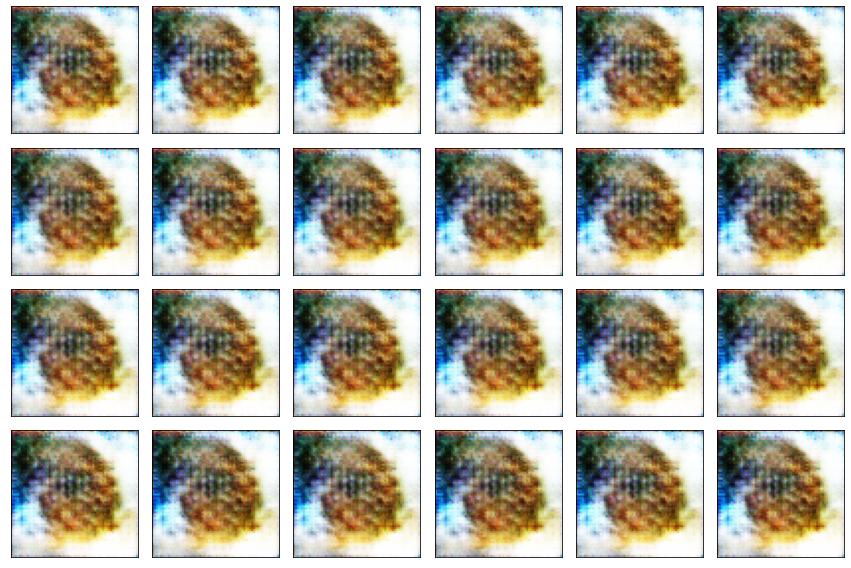

In [185]:
discriminator = make_discriminator_model()
generator = make_generator_model()

##### 0 to start over, N to start from an already trained GAN #####
start_from = 4500
if start_from > 0:
    discriminator.load_weights(f'first_model_checkpoints/discriminator/discriminator_{start_from}')
    generator.load_weights(f'first_model_checkpoints/generator/generator_{start_from}')

history, final_sample_images = train_gan(discriminator, generator, dataset_images.copy(), batch_size=8, 
                                         start_from=start_from, n_epochs=1500, n_save=50, model_name='first_model', 
                                         d_lr=0.000001, g_lr=0.00001)

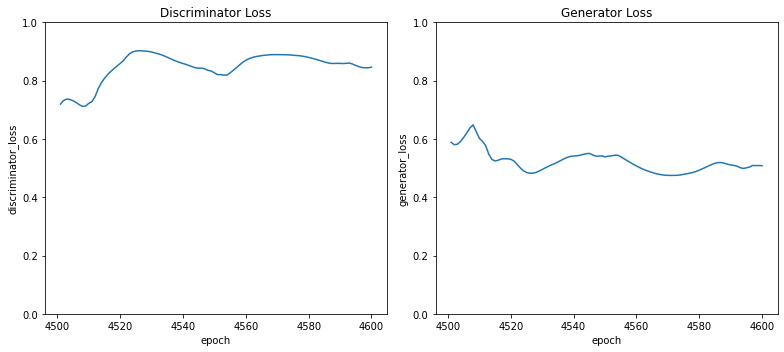

In [143]:
plot_all_score_vs_epochs(history, ma=100, loss_min=0.0, loss_max=1.0, start_from=start_from)

# New generator - upsampling instead of transpose conv

In [147]:
def convolution_block(n_filters):
    return [tf_layers.Conv2D(n_filters, (3, 3), padding='same'),
            tf_layers.BatchNormalization(),
            tf_layers.LeakyReLU(alpha=0.2)]

def upsampling_block(n_filters):
    return [tf_layers.UpSampling2D((2, 2)),
            *convolution_block(n_filters),
            *convolution_block(n_filters)]

def make_generator_with_upsampling():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(128,)),
        tf_layers.Dense(8192), # 8 * 8 * 128 = 8192
        tf_layers.Reshape((8, 8, 128)),
        *upsampling_block(64),
        *upsampling_block(128),
        *upsampling_block(256),
        tf_layers.Conv2D(3, (5, 5), padding='same', activation='sigmoid')
    ])

epoch 4501... [5.5 s] discriminator_loss:  0.14387, generator_loss:  0.00071
epoch 4502... [3.6 s] discriminator_loss:  0.45021, generator_loss:  0.00216
epoch 4503... [3.6 s] discriminator_loss:  0.61242, generator_loss:  0.48426
epoch 4504... [3.6 s] discriminator_loss:  0.46593, generator_loss:  0.08570
epoch 4505... [3.6 s] discriminator_loss:  0.31035, generator_loss:  0.09360
epoch 4506... [3.8 s] discriminator_loss:  0.30046, generator_loss:  0.07828
epoch 4507... [3.7 s] discriminator_loss:  0.19235, generator_loss:  0.05340
epoch 4508... [3.8 s] discriminator_loss:  0.14917, generator_loss:  0.03731
epoch 4509... [3.7 s] discriminator_loss:  0.10347, generator_loss:  0.04250
epoch 4510... [3.7 s] discriminator_loss:  0.18863, generator_loss:  0.06441
epoch 4511... [3.8 s] discriminator_loss:  0.18589, generator_loss:  0.01385
epoch 4512... [3.7 s] discriminator_loss:  0.13187, generator_loss:  0.01793
epoch 4513... [3.7 s] discriminator_loss:  0.10699, generator_loss:  0.00362

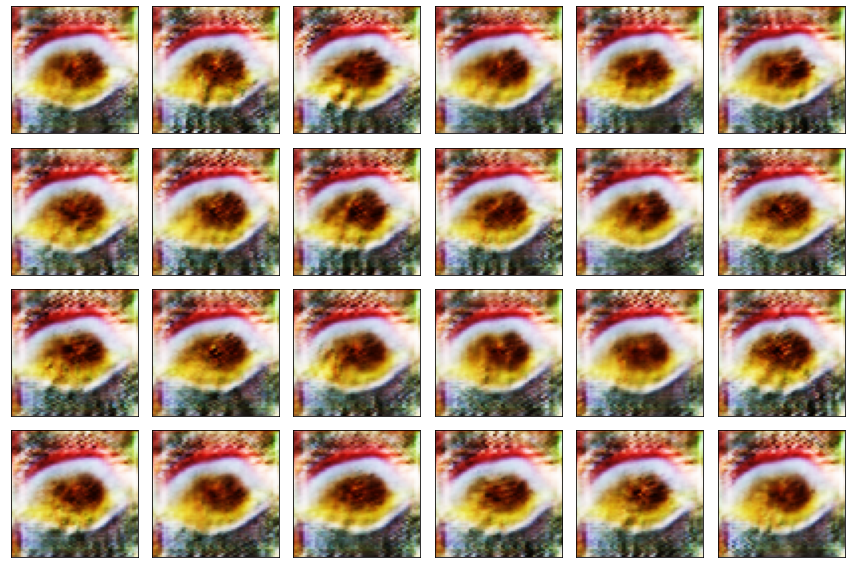

In [162]:
discriminator = make_discriminator_model()
generator = make_generator_with_upsampling()

##### 0 to start over, N to start from an already trained GAN #####
start_from = 4500
if start_from > 0:
    discriminator.load_weights(f'upsampling_model_checkpoints/discriminator/discriminator_{start_from}')
    generator.load_weights(f'upsampling_model_checkpoints/generator/generator_{start_from}')

history_2, final_sample_images_2 = train_gan(discriminator, generator, dataset_images.copy(), batch_size=8, 
                                             start_from=start_from, n_epochs=100, n_save=5, model_name='upsampling_model', 
                                             d_lr=0.000001, g_lr=0.000008)

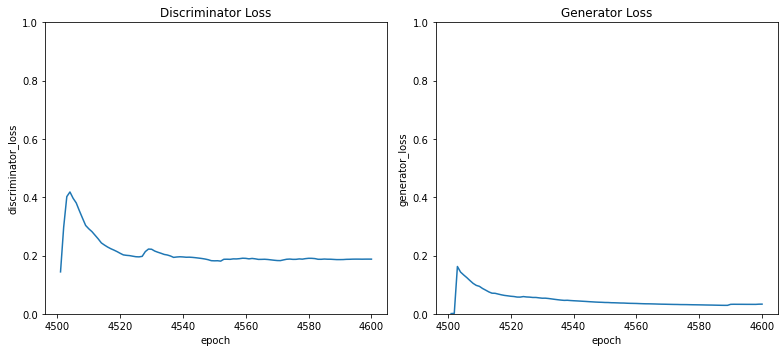

In [167]:
plot_all_score_vs_epochs(history_2, ma=100, loss_min=0.0, loss_max=1.0, start_from=start_from)